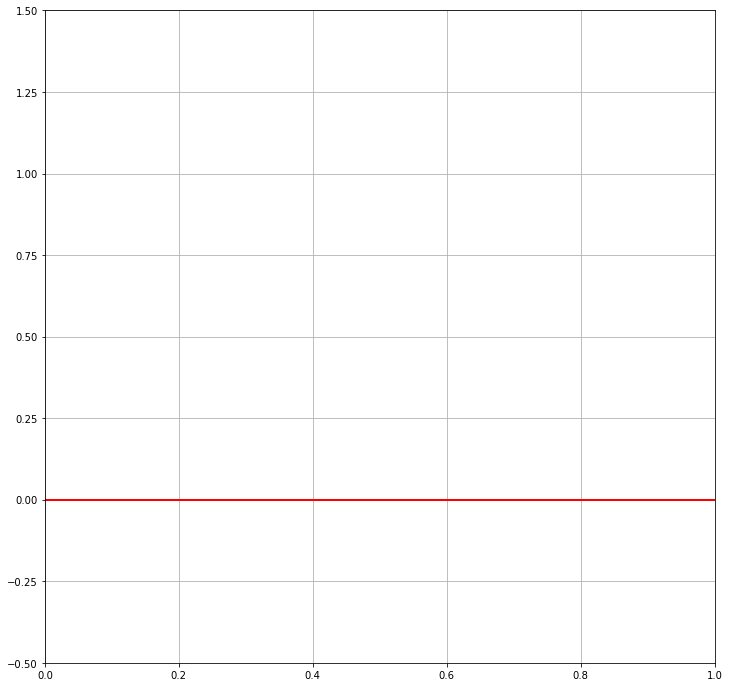

In [3]:
"""
Solve Advection Equation using upwind scheme

    dU / dt + C dU / dx = 0


* U(x,t)
* C: 0.5
* Initial condition: U(x, 0) = exp( - x^2 )
"""
import numpy as np
from optparse import OptionParser

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.use("Agg")

from matplotlib.offsetbox import AnchoredText

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation
import os

rc('animation', html='html5')

plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = 4000  # for 4 panel 73 frame, we need more than 3 GB
plt.rcParams['animation.ffmpeg_path'] = "/Users/louis.wicker/miniconda3/bin/ffmpeg"

# See things in the browser...
%matplotlib inline

global U
global UA
global xn
global tn
global X
global scheme

T = 1.0  # number of revs

# Sets up frame for animation plot

MyFigure, MyAxes = plt.subplots(figsize=(12,12))
MyLine, = MyAxes.plot([], [], lw=2)
MyAxes.set_xlim(( 0, 1.))
MyAxes.set_ylim((-0.5, 1.5))
MyAxes.grid()
MyAxes.plot([0., 1.0],[0.0,0.0], color='r', lw=2)

plotlays, plotcols = [2], ["black","gray"]
MyLines = []
for index in range(2):
    lobj = MyAxes.plot([],[],lw=2,color=plotcols[index])[0]
    MyLines.append(lobj)

#--------------------------------------------------------
"""

Solvers for 1D schemes - returns 1D x and 1D time array, and 
a 2D solution array dimensions U(x,t).  Code is set up to 
translate "T" revolutions

"""

def solver(scheme='LaxW', shape = 'square', nx = 100, C = 0.5):
    
    nlabel = T * np.arange(6) / 5.0
    
    ntimes = nx * nlabel / np.abs(C)
    ntimes = ntimes.astype('int64')
    
    nt = ntimes[-1]
      
    dt = T / ntimes[-1]    # dt
    dx = 1.0 / (nx - 1)    # dx
    
    U  = np.zeros((nx, nt+1))

    UA = np.zeros((nx, nt+1))

    
    # set up 1D time and space arrays
    
    tn = np.zeros((nt+2, 1))
    
    for n in np.arange(0, nt+2):
        tn[n] = n * dt
            
    xn = np.zeros((nx, 1))
    
    for i in np.arange(0, nx):
        xn[i] = i * dx
    
    # Set the initial values  z ranges from -0.5 to 0.5
        
    z = (nx*xn[:] * dx) - 0.5
    z = np.reshape(z, (nx,))
        
    if shape == 'square':
        U[:, 0] = 1.0 / (1.0 + np.exp(80.0*(np.abs(z) - .15 )))
    else:
        U[:, 0] = np.exp(- (z ** 2)/0.0125)
        
    # create analytical solution
    
    UA[:,0] = U[:,0]
    
    for n in np.arange(1, nt+1):
        
        znew = z - C*dx*n
        znew = np.where(znew >  0.5, znew-1., znew)
        znew = np.where(znew < -0.5, znew+1., znew)

        if shape == 'square':
            UA[:,n] = 1.0 / (1.0 + np.exp(80.0*(np.abs(znew) - .15 )))
        else:
            UA[:,n] = np.exp(- (znew ** 2)/0.0125)

    if scheme == 'LaxW':            
        for n in np.arange(1, nt+1):
            U[1:nx-1, n] = U[1:nx-1,n-1] - 0.5*C * (U[2:nx,n-1] - U[0:nx-2,n-1]) + 0.5*(C**2)*((U[2:nx,n-1] - 2*U[1:nx-1,n-1] + U[0:nx-2,n-1]))
                
            # Periodic BCs
            U[0,   n] = U[nx-2,n]
            U[nx-1,n] = U[1,   n]
            
    elif scheme == 'Euler':            
        for n in np.arange(1, nt+1):
            U[1:nx-1, n] = U[1:nx-1,n-1] - 0.5*C * (U[2:nx,n-1] - U[0:nx-2,n-1]) 
                
            # Periodic BCs
            U[0,   n] = U[nx-2,n]
            U[nx-1,n] = U[1,   n]
            
    elif scheme == 'WRF': 
        c0 = 37. / 60.0
        c1 = -8. / 60.0
        c2 =  1. / 60.0
        c3 = -1. / 60.0
        
        dir = 1.0
        if C < 0.0: dir = -1.
            
        for n in np.arange(1, nt+1):
            
            u1 = U[:,n-1] 
            
            for m in np.arange(3):
                
                step = C / (3.0 - m)
                
                uip2 = np.roll(u1,-2)
                uip1 = np.roll(u1,-1)
                uim1 = np.roll(u1, 1)
                uim2 = np.roll(u1, 2)
                uim3 = np.roll(u1, 3)
                
                f   = c0 * (u1   + uim1) \
                    + c1 * (uip1 + uim2) \
                    + c2 * (uip2 + uim3) \
                    + c3 * (uip2 - uim3 - 5.*(uip1-uim2)+10.*(u1-uim1))*dir
                
                fip1 = np.roll(f,-1)
                
                u1 = U[:,n-1] - step * (fip1 - f)
                            
            U[:,n] = u1[:]
 
    else:            
        for n in np.arange(1, nt+1):
            U[1:nx-1, n] = U[1:nx-1,n-1] - 0.5*C * (U[2:nx,n-1] - U[0:nx-2,n-1]) + 0.5*abs(C)*((U[2:nx,n-1] - 2*U[1:nx-1,n-1] + U[0:nx-2,n-1]))
    
            # Periodic BCs
            U[0,   n] = U[nx-2,n]
            U[nx-1,n] = U[1,   n]
            
    
#     anim.save('transport-equation.mp4', fps=int(ntimes[-1]/20), extra_args=['-vcodec', 'libx264'])

    return xn, tn, U, UA

def plot_artist(fig, x, t, U, scheme):
    
    ax_artists = []
    
    nt = t.shape[0]
        
    for n in np.arange(nt-1):
        
        ax = fig.add_subplot(1,1,1)
                    
        plot, = ax.plot(x, U[:, n], animated=True, color='k')
        time_text.set_text('Max Value:  %4.1f' % U[:,n].max())
        ax_artists.append([time_text,plot])
        
    
    plt.plot(x, U[:, 0], animated=True, color='r')
    plt.title("%s Scheme" % scheme, fontsize=30)
    plt.xlabel('X: position',fontsize=20)
    plt.ylabel('U(x, t)', fontsize=20)


    return ax_artists

def plot_function(n):
    
    # this is how you animate two lines
    xdata = [xn, xn]
    ydata = [U[:,n], UA[:,n]]
             
    for lnum,line in enumerate(MyLines):
       line.set_data(xdata[lnum], ydata[lnum])
    
    MyAxes.set_title("Analytical: (Gray) / Numerical Scheme: %s (Black) \n numerical max/min (%4.2f  %4.2f)" \
                     % (scheme, ydata[0].max(), ydata[0].min()), fontsize=15)
            
    return MyLine,  

In [8]:


shape  = 'gaussian'
#shape  = 'square'
scheme = 'LaxW'
scheme = 'WRF'
scheme = 'Euler'
scheme = 'Upwind'

xn, tn, U, UA = solver(nx=25, shape = shape, C = 0.2, scheme=scheme)

print("Computed numerical solution for %s scheme \n" % scheme)

anim = animation.FuncAnimation(MyFigure, plot_function, frames=tn.shape[0]-1, interval=100, blit=True, repeat=False)
print("Showing movie\n")
anim

Computed numerical solution for Upwind scheme 

Showing movie



In [ ]:
# This code is if you are going to create artist objects to be animated.

# #movie = plot_frame(fig, x, t, U, scheme)
# print("Made movie frames\n")




